<a href="https://colab.research.google.com/github/ViniciusTavaresSousa/Deteccao-de-Anomalias-Visuais-com-Autoencoder-Convolucional-e-SSIM-no-Dataset-MVTec-AD/blob/main/Autoencoder_MVTecAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import layers

#**Google Drive**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#**Utils**

Shape do array final: (209, 256, 256, 1)


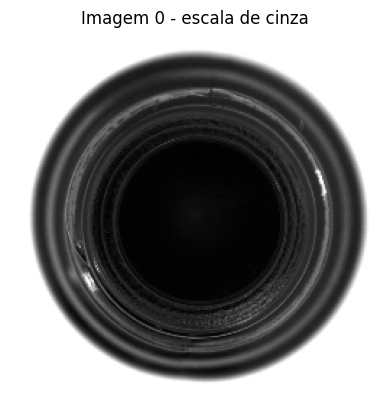

Array salvo com sucesso!


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Caminho da pasta com imagens
pasta = "/content/drive/MyDrive/PROJ_FINAL/mvtec/bottle/train/good"

# Lista para armazenar as imagens
imagens = []

# Percorrer os arquivos da pasta
for nome_arquivo in os.listdir(pasta):
    if nome_arquivo.lower().endswith(('.png', '.jpg', '.jpeg')):
        caminho = os.path.join(pasta, nome_arquivo)

        # Ler a imagem com OpenCV
        img = cv2.imread(caminho)

        # Converter para grayscale (único canal)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Redimensionar para 256x256
        img_gray = cv2.resize(img_gray, (256, 256))

        # Adicionar à lista
        imagens.append(img_gray)

# Converter para numpy array (shape: [N, 256, 256])
imagens_array = np.array(imagens, dtype=np.float32)
imagens_array = imagens_array[..., np.newaxis]

# Verificar forma final
print("Shape do array final:", imagens_array.shape)

# Exibir a primeira imagem do array (grayscale)
plt.imshow(imagens_array[0], cmap='gray')
plt.title("Imagem 0 - escala de cinza")
plt.axis('off')
plt.show()

# Salvar o array
np.save("/content/drive/MyDrive/PROJ_FINAL/bottle_dataset.npy", imagens_array)
print("Array salvo com sucesso!")


#**Configurações**

In [4]:
# Configurações
input_shape = (256, 256, 1)
latent_size = 128
batch_size = 8
epochs = 500

#**Base de Dados**

In [5]:
imagens_treinamento = np.load("/content/drive/MyDrive/PROJ_FINAL/bottle_dataset.npy")
imagens_treinamento = imagens_treinamento.astype('float32')
imagens_treinamento = imagens_treinamento / 255.0

In [6]:
imagens_treinamento.shape

(209, 256, 256, 1)

#**Modelo**

##**Encoder**

In [7]:
def criaEncoder():
    entrada = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(8, (5, 5), strides=(2, 2), padding='same')(entrada)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(512, (5, 5), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)
    saida = layers.Dense(latent_size)(x)

    modelo = tf.keras.Model(entrada, saida, name="Encoder")
    modelo.summary()

    return modelo

In [8]:
encoder = criaEncoder()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)    │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 512)      │         2,04

 Total params: 5,421,984 (20.68 MB)

 Trainable params: 5,419,952 (20.68 MB)

 Non-trainable params: 2,032 (7.94 KB)

##**Decoder**

In [9]:
def criaDecoder():
    entrada = tf.keras.Input(shape=(latent_size,))

    x = layers.Dense(4 * 4 * 512)(entrada)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Reshape((4, 4, 512))(x)

    x = layers.Conv2DTranspose(256, (5, 5), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(32, (5, 5), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(16, (5, 5), strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(8, (5, 5), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    saida = layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same', activation='sigmoid')(x)

    modelo = tf.keras.Model(entrada, saida, name="Decoder")
    modelo.summary()
    return modelo


In [10]:
decoder = criaDecoder()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 16)   │        12,816 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 16)   │            6

 Total params: 5,460,129 (20.83 MB)

 Trainable params: 5,442,737 (20.76 MB)

 Non-trainable params: 17,392 (67.94 KB)

##**Autoencoder**

In [11]:
autoencoder = tf.keras.Model(encoder.input, decoder(encoder.output), name="Autoencoder")
autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)    │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 512)      │         2,04

 Total params: 10,882,113 (41.51 MB)

 Trainable params: 10,862,689 (41.44 MB)

 Non-trainable params: 19,424 (75.88 KB)

##**Perda**

In [4]:
def perda(y_true, y_pred):

    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    perda_ssim = 1 - ssim

    return 0.5 * mse + 0.5 * perda_ssim

##**Treinamento**

In [13]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss=perda)

autoencoder.fit(imagens_treinamento,imagens_treinamento, epochs=epochs, batch_size=batch_size, shuffle=True)

Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 329ms/step - loss: 0.4329
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3478
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3344
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3177
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2815
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2336
Epoch 7/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1837
Epoch 8/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1368
Epoch 9/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1095
Epoch 10/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1034
Epoch 11/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0987
Epoch 12/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0975
Epoch 13/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0962
Epoch 14/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0947
Epoch 15/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - 

In [14]:
autoencoder.save("/content/drive/MyDrive/PROJ_FINAL/autoencoder.keras")

##**Resultados**

In [5]:
autoencoder = tf.keras.models.load_model("/content/drive/MyDrive/PROJ_FINAL/autoencoder.keras", custom_objects={"perda": perda})

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


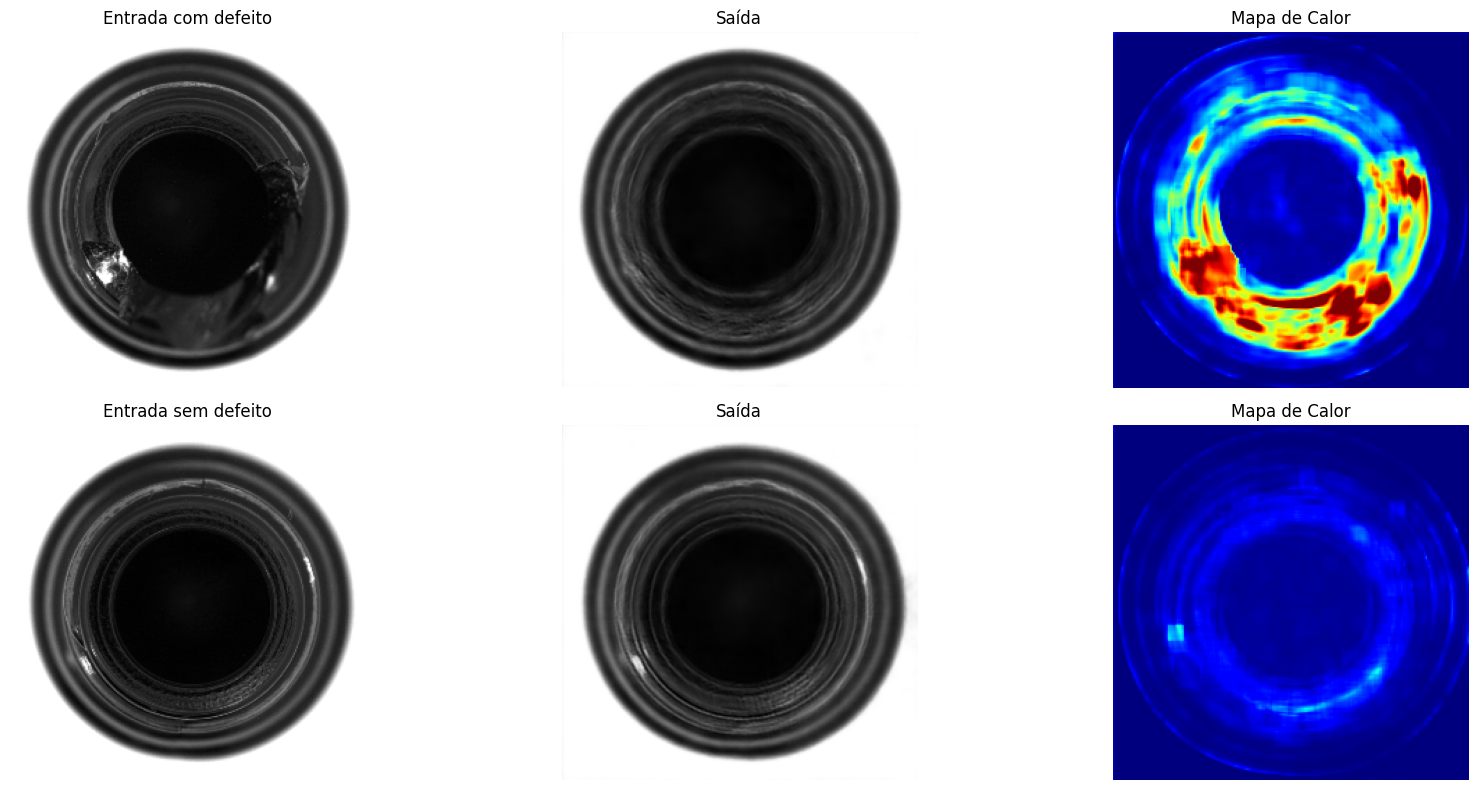

In [9]:
def carregar_imagens(pasta):
    imagens = []
    for nome_arquivo in os.listdir(pasta):
        if nome_arquivo.lower().endswith(('.png')):
            caminho = os.path.join(pasta, nome_arquivo)
            img = cv2.imread(caminho)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_gray = cv2.resize(img_gray, (256, 256))
            img_gray = img_gray.astype(np.float32) / 255.0
            imagens.append(img_gray)
    imagens_array = np.array(imagens, dtype=np.float32)[..., np.newaxis]
    return imagens_array

def ssim_map(img1, img2):

    img1 = tf.expand_dims(img1, axis=0)
    img2 = tf.expand_dims(img2, axis=0)

    patches1 = tf.image.extract_patches(images=img1,
                                        sizes=[1,11,11,1],
                                        strides=[1,1,1,1],
                                        rates=[1,1,1,1],
                                        padding='VALID')
    patches2 = tf.image.extract_patches(images=img2,
                                        sizes=[1,11,11,1],
                                        strides=[1,1,1,1],
                                        rates=[1,1,1,1],
                                        padding='VALID')

    patches1 = tf.reshape(patches1, [-1, 11*11])
    patches2 = tf.reshape(patches2, [-1, 11*11])

    def mean(x):
        return tf.reduce_mean(x, axis=1, keepdims=True)

    mu1 = mean(patches1)
    mu2 = mean(patches2)

    sigma1 = tf.math.reduce_variance(patches1, axis=1, keepdims=True)
    sigma2 = tf.math.reduce_variance(patches2, axis=1, keepdims=True)

    sigma12 = tf.reduce_mean((patches1 - mu1) * (patches2 - mu2), axis=1, keepdims=True)

    c1 = 0.01**2
    c2 = 0.03**2

    ssim_n = (2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)
    ssim_d = (mu1**2 + mu2**2 + c1) * (sigma1 + sigma2 + c2)
    ssim_val = ssim_n / ssim_d

    ssim_map = tf.reshape(ssim_val, [img1.shape[1]-10, img1.shape[2]-10])

    return ssim_map.numpy()

def comparar_imagens(modelo, img_defeito, img_boa):

    modelo_predict = lambda img: modelo.predict(img[np.newaxis, ...])[0]

    recon_defeito = modelo_predict(img_defeito)
    recon_boa = modelo_predict(img_boa)

    ssim_defeito = ssim_map(tf.convert_to_tensor(img_defeito, dtype=tf.float32),
                           tf.convert_to_tensor(recon_defeito, dtype=tf.float32))
    ssim_boa = ssim_map(tf.convert_to_tensor(img_boa, dtype=tf.float32),
                        tf.convert_to_tensor(recon_boa, dtype=tf.float32))

    erro_defeito = 1 - ssim_defeito
    erro_boa = 1 - ssim_boa

    plt.figure(figsize=(18, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(img_defeito.squeeze(), cmap='gray')
    plt.title("Entrada com defeito")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(recon_defeito, cmap='gray')
    plt.title("Saída")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(erro_defeito, cmap='jet', vmin=0, vmax=1)
    plt.title("Mapa de Calor")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(img_boa.squeeze(), cmap='gray')
    plt.title("Entrada sem defeito")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(recon_boa, cmap='gray')
    plt.title("Saída")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(erro_boa, cmap='jet', vmin=0, vmax=1)
    plt.title("Mapa de Calor")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

pasta_defeito = "/content/drive/MyDrive/PROJ_FINAL/mvtec/bottle/test/broken_large"
pasta_boa = "/content/drive/MyDrive/PROJ_FINAL/mvtec/bottle/train/good"

imgs_defeito = carregar_imagens(pasta_defeito)
imgs_boa = carregar_imagens(pasta_boa)

indice = 0

img_defeito = imgs_defeito[indice]
img_boa = imgs_boa[indice]

comparar_imagens(autoencoder, img_defeito, img_boa)